In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Making Pipeline
#from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Model/Dataset Split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

# accuracy information
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

In [2]:
## Read in the dataset
dataset = pd.read_csv('selected-features.csv', sep=',')
print("The total number of records are:", len(dataset))

The total number of records are: 556862


In [3]:
dataset.head()

,province,country,latitude,longitude,outcome,Confirmed,Deaths,Recovered,Active,Incidence_Rate,Case-Fatality_Ratio
0,437,57,23.02776,72.60027,1,-0.585089,-0.687288,-0.424015,-0.716747,-0.346762,-0.288237
1,627,93,-12.04318,-77.02824,2,-0.226881,0.050532,-0.623740,0.813937,-0.120737,-0.240932
2,437,57,23.02776,72.60027,1,-0.585089,-0.687288,-0.424015,-0.716747,-0.346762,-0.288237
3,497,93,-14.09402,-75.70284,2,-0.733892,-0.807013,-0.623740,-0.680020,-0.171325,-0.163267
4,328,57,28.61474,77.20910,1,-0.399604,-0.575751,-0.224839,-0.639158,-0.267352,-0.313195


In [4]:
# Extract class labels
y = dataset['outcome'].copy() 
X = dataset.drop('outcome', axis=1)

In [5]:
# Outcome "0" is deceased
y.unique() # There are only 4 possible labels for this

array([1, 2, 3, 0])

In [6]:
X.columns.to_list() # These are the features.

['province',
 'country',
 'latitude',
 'longitude',
 'Confirmed',
 'Deaths',
 'Recovered',
 'Active',
 'Incidence_Rate',
 'Case-Fatality_Ratio']

In [7]:
# Here we use the "random_state" parameter to make the models reproducible.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [8]:
X_train.shape

(417646, 10)

In [9]:
#Inspect Training Dataset for imbalance
# Class 0 is deceased
y_train.value_counts()

2    187407
1    152352
3     73430
0      4457
Name: outcome, dtype: int64

In [10]:
#Inspect Training Dataset for imbalance
y_test.value_counts()

2    62168
1    50874
3    24674
0     1500
Name: outcome, dtype: int64

In [11]:
adaModel = AdaBoostClassifier(random_state=1)

In [12]:
dec_tree_classifiers = list()
# We do not want to have a decision tree that is "too strong" so 
# keep these numbers low.
for n in [1,3,5,8,10]:
  dec_mod = DecisionTreeClassifier(max_depth=n, random_state=1)
  dec_tree_classifiers.append(dec_mod)

In [13]:
num_estimators = [10,50,500,1000]
learn_rate = [0.001, 0.01, 0.1, 0.5,1]

In [14]:
parameters = {'base_estimator':dec_tree_classifiers,'n_estimators': num_estimators, 'learning_rate':learn_rate}

In [15]:
def custom_recall_scorer(y, y_pred):
    # The '0' label contains the decased. Since we want to maximize the recall only on that,
    # we only return that score
    r_score = recall_score(y, y_pred, average=None, labels=[0,1,2,3])
    #print("Score is", r_score)
    return r_score[0]

recall_scorer = make_scorer(custom_recall_scorer, greater_is_better=True)
#recall_scorer

In [16]:
# Create the model
gridCV = GridSearchCV(estimator=adaModel,param_grid=parameters, verbose=3, scoring=recall_scorer, n_jobs=-1, cv=3)

In [17]:
cv_results = gridCV.fit(X_train, y_train)
print("Finished Grid Search!")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:
gridCV.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=6,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [ ]:
mod = gridCV.best_estimator_
mod.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=6,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [ ]:
#Function to evaluate models and print our relevant statistics/plots
def EvaluateModel(X_true, y_true, y_pred, X_train, y_train, model):
    #Classification Report
    print("________________________________________")
    print("Classification Report\n")
    report = classification_report(y_true,y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose().round(3)
    display(report_df)

    #Train and Test Scores
    print("________________________________________")
    print("Train and Test Scores\n")
    print("Training Accuracy Score: ", model.score(X_train, y_train))
    print("Testing Accuracy Score: ", model.score(X_true, y_true))
    
    #Plot Confusion Matrix
    print("________________________________________")
    print("Confusion Matrix\n")
    plot_confusion_matrix(model,X_true,y_true,cmap='gnuplot',normalize='true')
    plt.show()

In [ ]:
y_pred = mod.predict(X_test)

________________________________________
Classification Report



,precision,recall,f1-score,support
0,0.022,0.049,0.030,1500.000
1,0.689,0.781,0.732,50874.000
2,0.983,0.983,0.983,62168.000
3,0.373,0.242,0.293,24674.000
accuracy,0.768,0.768,0.768,0.768
macro avg,0.517,0.514,0.510,139216.000
weighted avg,0.757,0.768,0.759,139216.000


________________________________________
Train and Test Scores

Training Accuracy Score:  0.7682989900537776
Testing Accuracy Score:  0.7679648890932077
________________________________________
Confusion Matrix



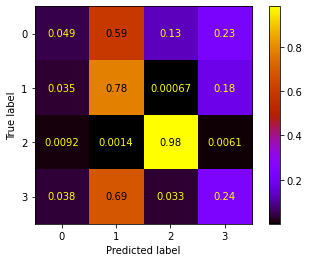

In [ ]:
EvaluateModel(X_test, y_test, y_pred, X_train, y_train, mod)

In [ ]:
# Experiment with recall score
#truth = [0,1,1,0,2]
#pred = [0,2,1,0,1]
#a = recall_score(truth, pred, average=None, labels=[0,1,2])
#print(a[0])

1.0
